In [1]:
%%capture
%run full_setup.py

In [2]:
from tfidf_corpus_dictionary import get_tfidf_tokendocs_corpus_dict
from gensim.models import LdaModel, LsiModel, CoherenceModel
from sklearn.decomposition import NMF, PCA
from sklearn.random_projection import GaussianRandomProjection, SparseRandomProjection
import numpy as np
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns
import os

With this function we get various objects needed for modelling:
1. TFIDF matrix as input data, with specified parameters
2. feature names as the words retained with TFIDF
3. tokenized documents, a list of lists, where the inner lists contain the tokens for each document
4. corpus, gensim object needed for modelling with that package
4. dictionary, gensim object containing informations on the words of the corpus and their positions

In [3]:
tfidf_matrix, feature_names, tokenized_docs, corpus, dictionary = get_tfidf_tokendocs_corpus_dict(df, max_df=0.5, min_df=5, max_features=1000)

Now we'll evaluate different topic models based on Coherence score.

Coherence is a metric used to evalute topics quality. The higher the coherence, the better the model did in creating the topics.

For every model we'll use a function to retrieve coherence for different numbers of topics (5, 10, 15, 20, 50). This information will be used to evaluate how the models performed as the number of topics changes

In [4]:
from coherence_by_topics import coherence_by_topics
from coherence_by_words import coherence_by_words

In [5]:
topics = [5, 10, 20, 50]

In [6]:
evaluation_by_topics = {}

for n_topics in topics:
    metrics_words = coherence_by_topics(n = n_topics, corpus=corpus, dictionary=dictionary,
                               texts=tokenized_docs, feature_names=feature_names, tfidf=tfidf_matrix)
    
    evaluation_by_topics[n_topics] = metrics_words

In [7]:
evaluation_by_topics[5]

[('LDA', 0.5179),
 ('LSA', 0.5469),
 ('NMF', 0.6479),
 ('PCA', 0.5464),
 ('RP', 0.2019)]

In [8]:
evaluation_by_topics[10]

[('LDA', 0.5264),
 ('LSA', 0.4587),
 ('NMF', 0.6736),
 ('PCA', 0.4517),
 ('RP', 0.2012)]

In [9]:
evaluation_by_topics[20]

[('LDA', 0.3957),
 ('LSA', 0.382),
 ('NMF', 0.633),
 ('PCA', 0.3656),
 ('RP', 0.2071)]

In [10]:
evaluation_by_topics[50]

[('LDA', 0.3593),
 ('LSA', 0.3138),
 ('NMF', 0.5271),
 ('PCA', 0.3193),
 ('RP', 0.2112)]

In [11]:
words = [10, 100, 1000, 10000]

In [12]:
evaluation_by_words = {}

for n_words in words:
    metrics_words = coherence_by_words(df, n = n_words)
    evaluation_by_words[n_words] = metrics_words

In [13]:
evaluation_by_words[10]

[('LDA', 0.4661),
 ('LSA', 0.4661),
 ('NMF', 0.4661),
 ('PCA', 0.4661),
 ('RP', 0.4661)]

In [14]:
evaluation_by_words[100]

[('LDA', 0.4183),
 ('LSA', 0.3723),
 ('NMF', 0.4723),
 ('PCA', 0.387),
 ('RP', 0.3258)]

In [15]:
evaluation_by_words[1000]

[('LDA', 0.5179),
 ('LSA', 0.5469),
 ('NMF', 0.6479),
 ('PCA', 0.5464),
 ('RP', 0.2019)]

In [16]:
evaluation_by_words[10000]

[('LDA', 0.4755),
 ('LSA', 0.4596),
 ('NMF', 0.7112),
 ('PCA', 0.625),
 ('RP', 0.6706)]

In [17]:
def plots(evaluation, type: str):
    for n, metrics in evaluation.items():
        model_names, coherence_values = zip(*metrics)

        # Create a DataFrame for easy plotting with Seaborn
        data = {'Model': model_names, 'Coherence Value': coherence_values}
        df = pd.DataFrame(data)

        plt.figure(figsize=(8, 5))
        
        # Use Seaborn's barplot with the hue parameter
        sns.barplot(x='Model', y='Coherence Value', data=df, hue='Model', palette='viridis')
        
        plt.xlabel('Model')
        plt.ylabel('Coherence Value')
        plt.title(f'Coherence Evaluation for {n} Words')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        
        figures_folder = R'C:\Users\andre\OneDrive - Alma Mater Studiorum Università di Bologna\University\UniBo\Machine Learning\PR1.20\figures'
        save_path = os.path.join(figures_folder, f'coherence_evaluation_{n}_{type}')
        
        plt.savefig(save_path)
        plt.show()

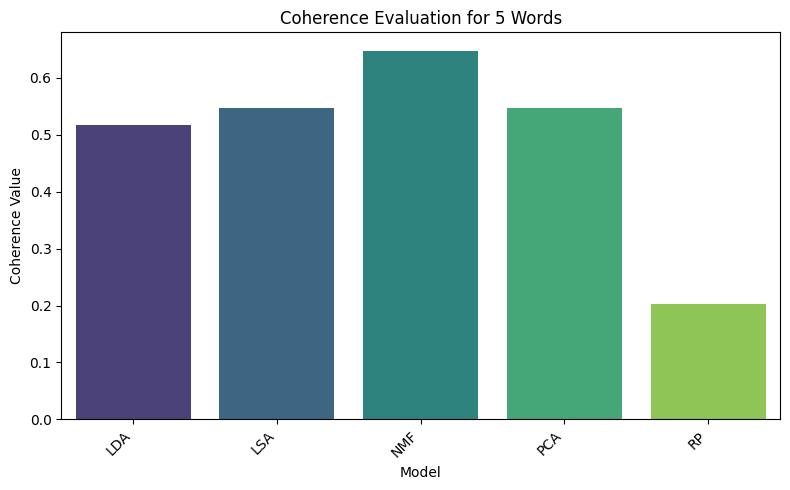

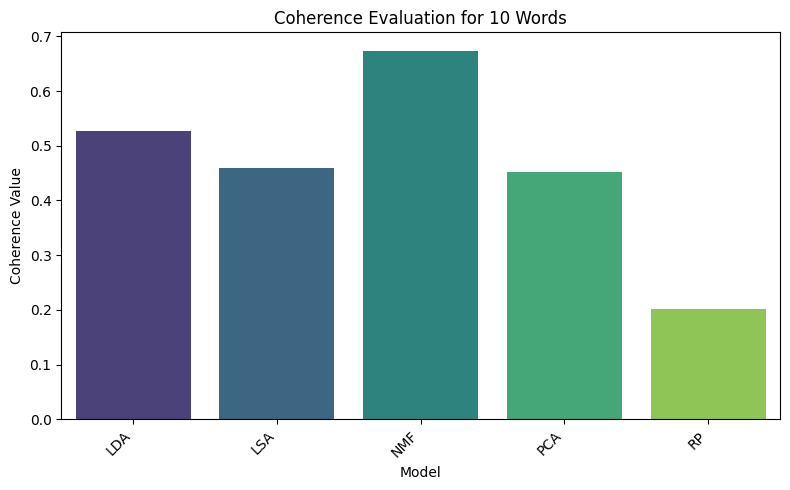

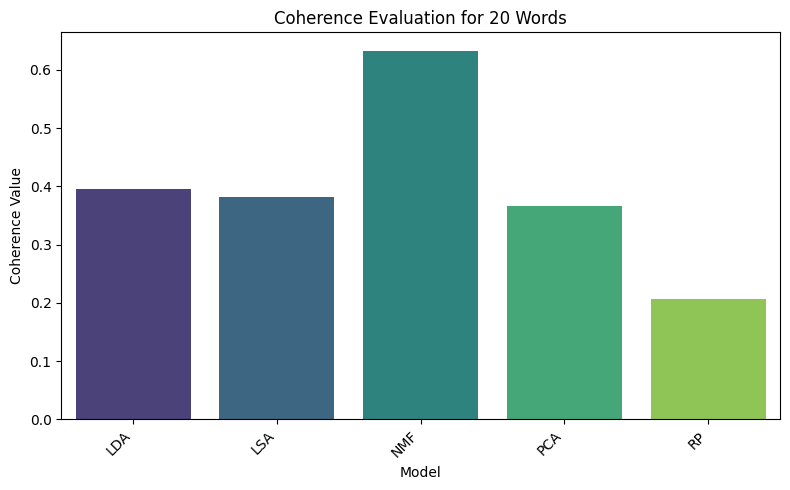

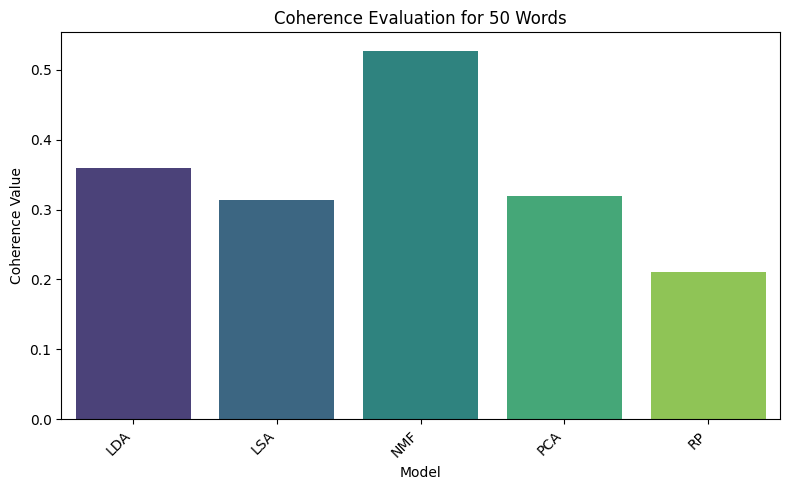

In [18]:
plots(evaluation_by_topics, 'topics')

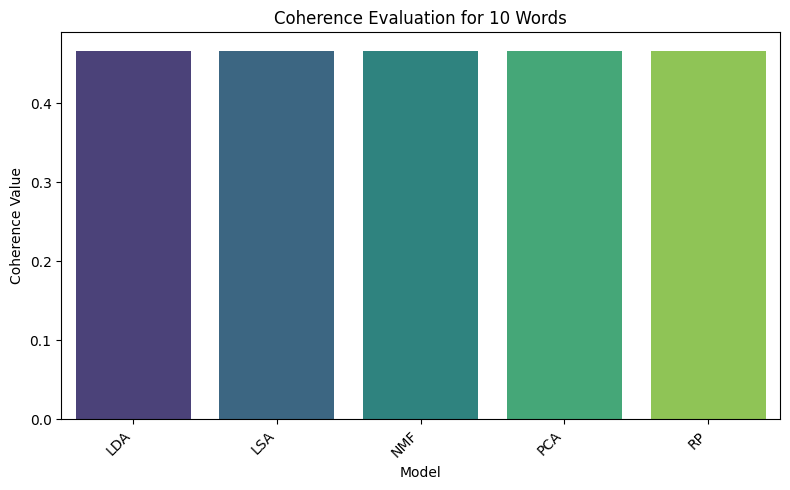

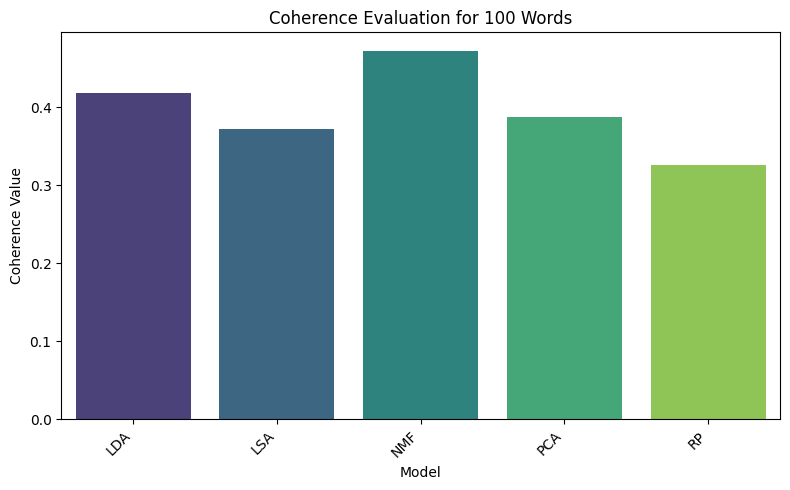

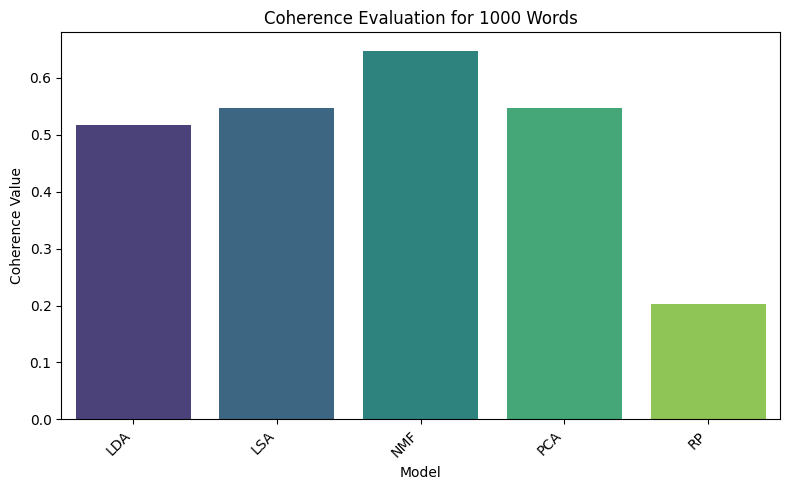

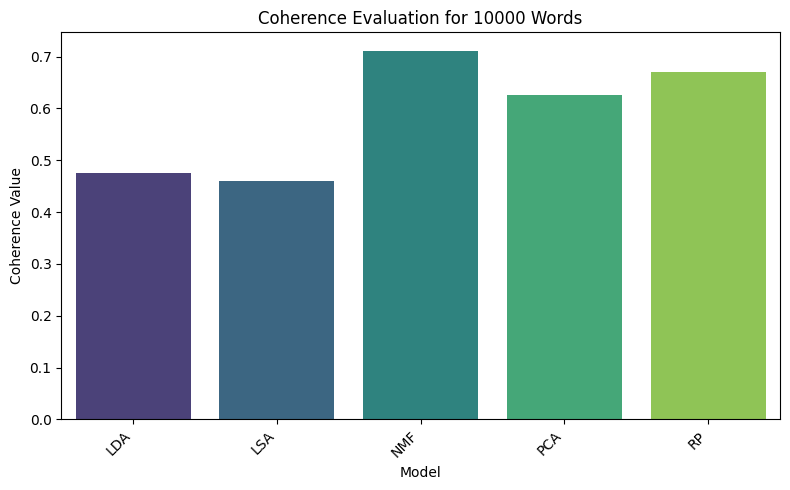

In [19]:
plots(evaluation_by_words, 'words')

In [44]:
from display_topics import display_topics

Now we'll fit the LDA model with the number of topics that yields the highest coherence

In [17]:
lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=5,
                     alpha='symmetric', eta='auto', passes=5, random_state=1)

In [46]:
display_topics('LDA', lda_model, feature_names)

Topic 1: government, law, gun, state, drug, tax, clinton, case, evidence, believe, year, mean, child, american, point
Topic 2: god, israel, israeli, christian, armenian, jew, jesus, arab, turkish, church, jewish, bible, kill, believe, life
Topic 3: car, game, drive, player, year, team, sale, play, power, buy, usa, work, distribution, back, price
Topic 4: apr, distribution, space, clipper, 1993, phone, gordon, computer, bank, chip, 11, message, email, usa, encryption
Topic 5: window, file, program, system, problem, help, work, card, software, email, space, run, key, version, computer


Now we're going to do the same for LSA

In [47]:
lsi_model = LsiModel(corpus, id2word=dictionary, num_topics=5, random_seed = 1)

In [48]:
display_topics('LSA', lsi_model, feature_names)

Topic 1: system, work, year, problem, distribution, window, god, drive, computer, run, file, state, car, world, help
Topic 2: god, window, file, card, christian, drive, driver, jesus, program, believe, email, system, disk, software, version
Topic 3: game, team, god, player, win, play, year, season, hockey, christian, window, file, jesus, baseball, score
Topic 4: window, god, key, file, chip, car, game, clipper, encryption, government, team, christian, jesus, win, drive
Topic 5: drive, car, key, file, chip, clipper, encryption, window, god, card, scsi, sale, government, program, bike


In [22]:
nmf_model = NMF(n_components=10, random_state=1).fit(tfidf_matrix)

In [49]:
display_topics('NMF', nmf_model, feature_names)

Topic 1: gun, state, government, israel, israeli, law, armenian, kill, year, case, child, country, point, war, jew
Topic 2: window, file, program, run, problem, application, manager, 31, help, server, windows, image, display, directory, screen
Topic 3: game, team, win, player, play, year, season, hockey, score, baseball, fan, playoff, nhl, league, run
Topic 4: god, christian, jesus, bible, believe, christ, faith, church, atheist, life, belief, sin, religion, christianity, truth
Topic 5: email, distribution, sale, usa, 11, space, computer, post, mail, list, system, version, send, information, address
Topic 6: key, chip, clipper, encryption, system, government, algorithm, phone, secret, security, secure, public, privacy, de, house
Topic 7: card, driver, video, monitor, color, mode, graphic, bus, board, mouse, port, support, ram, work, problem
Topic 8: car, bike, engine, buy, price, speed, dealer, mile, model, oil, sell, front, light, insurance, dod
Topic 9: drive, scsi, disk, hard, ide, 

In [50]:
tfidf_matrix_dense = tfidf_matrix.todense() if sparse.issparse(tfidf_matrix) else tfidf_matrix

# Convert to numpy array
tfidf_matrix_array = np.asarray(tfidf_matrix_dense)

# Centering
mean_tfidf = np.mean(tfidf_matrix_array, axis=0)  # Calculate the mean of each column
centered_tfidf_matrix = tfidf_matrix_array - mean_tfidf

pca_model = PCA(n_components=5, random_state=1).fit(centered_tfidf_matrix)

In [51]:
display_topics('PCA', pca_model, feature_names)

Topic 1: god, christian, jesus, believe, law, bible, year, life, jew, church, religion, team, christ, government, faith
Topic 2: game, team, player, win, play, year, season, hockey, baseball, score, fan, playoff, nhl, league, toronto
Topic 3: key, chip, car, clipper, encryption, government, drive, gun, system, phone, buy, law, algorithm, bike, security
Topic 4: key, file, chip, window, clipper, encryption, government, program, team, game, algorithm, security, public, win, secret
Topic 5: god, chip, key, game, clipper, drive, card, encryption, scsi, system, jesus, christian, sale, team, mac


In [52]:
rp_model = GaussianRandomProjection(n_components=5, random_state=1).fit(tfidf_matrix)

In [53]:
display_topics('RP', rp_model, feature_names)

Topic 1: maybe, ram, effect, change, play, context, standard, shall, source, center, burn, allow, firearm, full, accord
Topic 2: obviously, convert, example, free, 44, graphic, phone, although, bible, commit, reference, within, port, handle, search
Topic 3: freedom, sign, side, cost, reach, couldnt, believe, course, publish, san, bit, isnt, arent, relate, discuss
Topic 4: account, thought, site, thousand, suggestion, within, effort, high, user, establish, blood, suggest, 30, lose, via
Topic 5: average, gary, control, mile, medical, provide, love, series, corporation, charge, compute, frank, concern, exist, youre
